In [5]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn
% matplotlib inline

from scipy.stats import gennorm

import pandas as pd

## Approach to the sum (mean) of 10^N(0,s)

In [2]:
# We use a perfect normal. For increasing N, what is the expectation of this sum? 
# can we find the analytical expression for it? should it be the lognormal? what if growth rates where different? eg Laplace.

In [3]:
# # Pareto... for size dist

# from scipy.stats import pareto
# b = 1.1771
# fig, ax = plt.subplots(1, 1)
# x = np.linspace(pareto.ppf(0.01, b), pareto.ppf(0.99, b), 100)
# ax.plot(x, pareto.pdf(x, b), 'r-', lw=5, alpha=0.6, label='pareto pdf')
# ax.set_xscale('log')
# ax.set_yscale('log')

In [6]:
data_path = './../../data/processed/'

df = pd.read_csv(data_path + 'ID_Y.csv')
df = df.loc[df.IMPORT == 0]

cuadro = df.set_index(['ID', 'YEAR'])[['VART']].unstack()

# Firms present in at least some time periods
cuadro = cuadro.loc[cuadro.count(1) > 12]
cuadro_rolled = cuadro

annual_logdiff = np.log10(cuadro_rolled).diff(1, axis = 1).replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna(how = 'all')
annual_log = np.log10(cuadro_rolled.reindex(annual_logdiff.index))

annual_log.columns = annual_log.columns.set_levels(annual_log.columns.levels[0].str.replace('VART', 'annual_log'), level=0)
annual_logdiff.columns = annual_logdiff.columns.set_levels(annual_logdiff.columns.levels[0].str.replace('VART', 'annual_logdiff'), level=0)

df_concat = pd.concat([annual_log, annual_logdiff], axis = 1)

df_level_g = df_concat.stack()

g_rates = df_level_g.dropna()['annual_logdiff']
g_rates_val = g_rates.values

In [7]:
g_rates_clip = np.clip(g_rates, -1.8, 1.8)
g_rates_val = g_rates_clip.values

In [12]:
M = 60000 #repetitions
mu0 = 6 # initial size. not really necessary but...

result = []
for j, dist in enumerate(['norm', 'lapl', 'sbtn', 'emp_clp']): # distribution
    for i, n in enumerate([100, 1000]):
        x0 = mu0*np.ones(n)

        out = []
        for s in np.arange(0.1, 0.6, 0.1):
            
            
            t = []
            for m in range(M):
                if dist == 'norm':
                    g_rates = np.random.normal(0, s, n)
                elif dist == 'lapl':
                    g_rates = np.random.laplace(0, s, n)/np.sqrt(2)
                elif dist == 'sbtn':
                    g_rates = gennorm.rvs(1/2, size = n)* (s / 10.925)
                else:
                    g_rates = np.random.choice(g_rates_val, n)
                    g_rates = s*(g_rates/g_rates.std())
                t += [np.power(10, x0 + g_rates).sum()/(n*10**mu0)]
            out += [np.array(t)]
        result += [out]

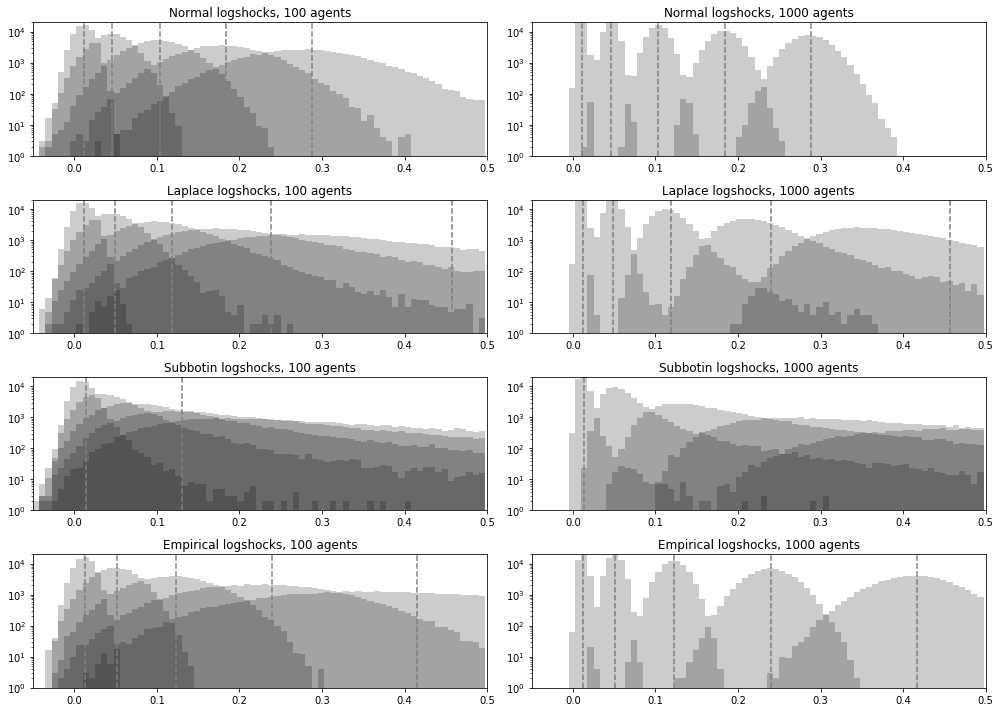

In [17]:
# If 1000 agents worth one million, have normally distributited geometric growth rates... 
fig, axs = plt.subplots(4, 2, figsize = (14, 10))

for j, dist in enumerate(['norm', 'lapl', 'sbtn', 'emp_clp']): # distribution
    for i, n in enumerate([100, 1000]):
        out = result[2*j + i]
        ax = axs[j][i]
        bins = np.arange(-0.05, 0.5, 0.0075)
        for outcome in out:
            ax.hist(np.log10(outcome), bins, alpha = .2, color = 'k')
            ax.axvline(np.log10(np.mean(outcome)), color = '.5', linestyle = '--')
        ax.set_title(['Normal', 'Laplace', 'Subbotin', 'Empirical'][j]+' logshocks, '+str(n)+' agents')
        ax.set_yscale('log')
        ax.set_xlim(-0.05, 0.5)
        ax.set_ylim(1, 20000)
        

plt.tight_layout()
plt.savefig('./../../../WRITING/paper1_writing/figures/power_sum_expectation_2.png', dpi = 250)
plt.show()

In [4]:
(.1**2)*np.log(10)/2

0.011512925464970231

In [5]:
# If 1000 agents worth one million, have normally distributited geometric growth rates... 

result = []

for n in [10, 100, 1000, 5000]:
    print(n)
    mu0 = 6
    x0 = mu0*np.ones(n)

    for sigma in np.arange(.01, 1.41, .1):
    # for sigma in np.arange(.01, 10.01, .5):
        t = []
        for m in range(10000):
            x1 = np.random.normal(0, sigma, n)
            t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]
        s2 = np.array(t)
        result += [[n, sigma, np.log10(s2).mean(), np.log10(s2).std()]]
# # plt.hist(np.log10(s1), 70, alpha = .5)
# # plt.hist(np.log10(s2), 70, alpha = .5)
# # plt.yscale('log')
# # plt.xlim(-0.15, 0.2)

# # plt.show()


10
100
1000
5000


In [6]:
import pandas as pd

In [7]:
df = pd.DataFrame(result, columns = ['n','sigma', 'M', 'S'])
df.head()

,n,sigma,M,S
0,10,0.01,0.000114,0.003154
1,10,0.11,0.011927,0.034760
2,10,0.21,0.045643,0.070022
3,10,0.31,0.097314,0.109626
4,10,0.41,0.165092,0.153692


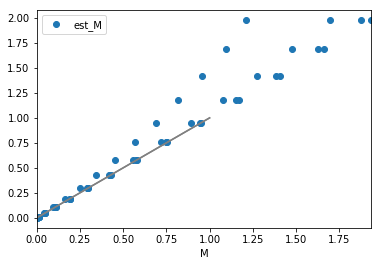

In [8]:
df['est_M'] = (df.sigma**2)*np.log(10)/2
# df.head(20).plot('M', 'est_M', lw = 0, marker = 'o')
df.plot('M', 'est_M', lw = 0, marker = 'o')
plt.plot([[0, 0], [1, 1]], c = '.5')


In [13]:
import warnings
warnings.filterwarnings('ignore')

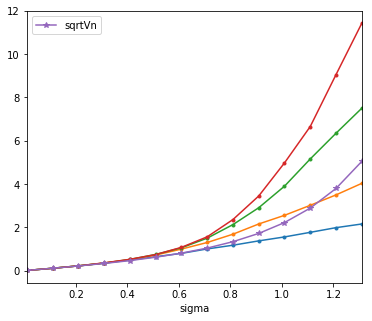

In [32]:
fig, ax = plt.subplots(1, figsize = (6, 5))
# df['S'] = np.sqrt(df.S)
# df['M'] = np.sqrt(df.M)
for n in [10, 100, 1000, 5000]:
    df_ = df.loc[df.n == n]
    df_['y'] = df_['S']*np.sqrt(n)
    l10 = np.log(10)
    df_['sqrtVn'] = np.sqrt((np.exp(df['sigma']**2))*(np.exp(df['sigma']**2) - 1))
#     df_['sqrtVn1'] = df['sigma']
#     df_['sqrtVn1'] = np.sqrt((df['sigma']**2)/n) 
#     df_['sqrtVn2'] = np.sqrt((df['sigma']**2 + 3/2* df['sigma']**4)) 
    df_.plot('sigma', 'y', marker = '.', ax = ax, label = '_')
df_.plot('sigma', 'sqrtVn', marker = '*', ax = ax)
#     df_.plot('sigma', 'sqrtVn2', marker = '*', ax = ax)
    
ax.legend()
# plt.ylim(0, 0.5)
# plt.xlim(0, .45)

# plt.plot([[0, 0], [1, 1]])
# df.plot('sigma', 'M', marker = '.', ax = ax)
# plt.yscale('log')


/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be se

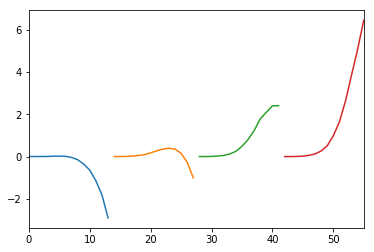

In [93]:
for n in [10, 100, 1000, 5000]:
    df_ = df.loc[df.n == n]
    df_['y'] = df_['S']*np.sqrt(n)
    df_['sqrtVn'] = np.sqrt((np.exp(df['sigma']**2))*(np.exp(df['sigma']**2) - 1))
    (df_['y'] - df_['sqrtVn']).plot()

In [10]:
# t = []
# for m in range(10000):
#     x1 = np.random.normal(0, 0.16, 1000)
#     t += [np.power(10, x0 + x1).sum()]
# s2 = np.array(t)

## What is the consequnce of fat tailed shocks instead of normal?


In [9]:
import pandas as pd

In [10]:
data_path = './../../data/processed/'
# col = 'ID'
# df = pd.read_csv(data_path + col.replace(' ', '_')+'_YM.csv')
# # df['date'] = pd.to_datetime(df.MONTH.astype(str) + '/' + df.YEAR.astype(str), format = '%m/%Y')
# df['date'] = pd.DatetimeIndex(pd.to_datetime(12*(df.YEAR - 1997) + df.MONTH, unit='M', origin=pd.Timestamp('1996-12-15'))).round('D')


In [11]:
df = pd.read_csv(data_path + 'ID_Y.csv')
df = df.loc[df.IMPORT == 0]

cuadro = df.set_index(['ID', 'YEAR'])[['VART']].unstack()

# Firms present in at least some time periods
cuadro = cuadro.loc[cuadro.count(1) > 12]
cuadro_rolled = cuadro

annual_logdiff = np.log10(cuadro_rolled).diff(1, axis = 1).replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna(how = 'all')
annual_log = np.log10(cuadro_rolled.reindex(annual_logdiff.index))

annual_log.columns = annual_log.columns.set_levels(annual_log.columns.levels[0].str.replace('VART', 'annual_log'), level=0)
annual_logdiff.columns = annual_logdiff.columns.set_levels(annual_logdiff.columns.levels[0].str.replace('VART', 'annual_logdiff'), level=0)

df_concat = pd.concat([annual_log, annual_logdiff], axis = 1)

df_level_g = df_concat.stack()

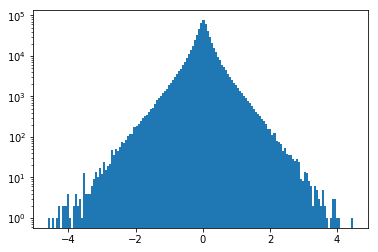

0.4273679067783249

In [43]:
g_rates = df_level_g.dropna()['annual_logdiff']
plt.hist(g_rates.values, 150)
plt.yscale('log')
plt.show()
g_rates.std()

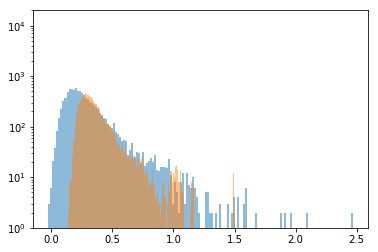

In [51]:
fig, ax = plt.subplots(1)

g_rates_val = g_rates.values

for n in [100, 1000]:
    mu0 = 6
    x0 = mu0*np.ones(n)

    t = []
    for m in range(10000):
    #     x1 = np.random.normal(0, 0.2, n)
        x1 = np.random.choice(g_rates_val, n)
        t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]

    s1 = np.array(t)
    
    ax.hist(np.log10(s1), 150, alpha = .5)
    ax.set_yscale('log')
#     ax.set_xlim(-0.05, 0.3)
    ax.set_ylim(1, 20000)

plt.show()


In [16]:
g_rates

ID         YEAR
0          1998   -0.185783
           1999    0.238089
           2000   -0.468011
           2001    0.598355
           2002   -0.572908
           2003   -0.165896
           2004    0.201865
           2005   -0.309953
           2006    0.218063
           2007   -0.001157
           2008    0.562737
           2009   -0.717832
           2010    0.995854
           2011   -1.832025
           2012   -1.036919
           2013   -2.073075
215        1998    0.089831
           1999   -0.439749
           2000    0.632361
           2001    0.273251
           2002   -0.055173
           2003   -0.425677
           2004    0.113632
           2005   -0.215759
           2006   -0.303695
           2007   -0.208859
           2008    0.118482
           2009   -0.866323
           2010    0.827865
           2011   -1.484762
                     ...   
999990401  2000    0.126684
           2001    0.022977
           2002   -0.183659
           2003    0.113473
    

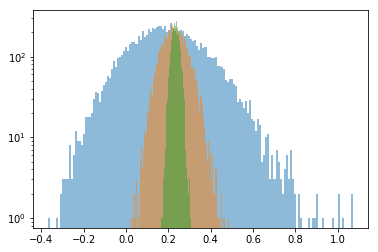

In [82]:

g_rates_val = g_rates.values

for n in [10, 100, 1000]:
    mu0 = 6
    x0 = mu0*np.ones(n)

    t = []
    for m in range(10000):
        x1 = np.random.normal(0, 0.4524, n)
#         x1 = np.random.choice(g_rates_val, n)
        t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]

    s1 = np.array(t)
    
    plt.hist(np.log10(s1), 150, alpha = .5)
    plt.yscale('log')
#     plt.xlim(-0.15, 0.2)

plt.show()


### Addition of evolved quantiles
if they have different sigma.
The volatility of the total will come from volatility of the quantiles that make it up.

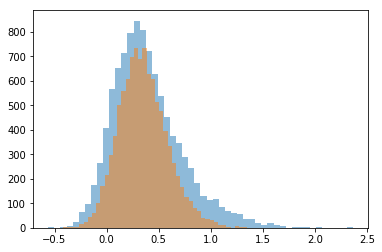

In [5]:
s1 = .2
s2 = .6
s3 = .4

n1 = np.random.normal(0, s1, 10000)
n2 = np.random.normal(0, s2, 10000)
n3 = np.random.normal(0, s3, 10000)

plt.hist(np.log10(np.power(10, n1) + np.power(10, n2)), bins = 50, alpha = .5)


plt.hist(np.log10(np.power(10, n1) + np.power(10, n3)), bins = 50, alpha = .5)
# plt.xscale('log')
plt.show()

In [6]:
def test(s1, s2):
    result = np.log10(np.power(10, np.random.normal(0, s1, 40000)) + np.power(10, np.random.normal(0, s2, 40000)))
    return result.mean(), result.std()

# def test(s1, s2):
#     result = np.random.normal(0, s1, 40000) + np.random.normal(0, s2, 40000)
#     return result.mean(), result.std()

In [7]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [9]:
delta = 0.1
x = np.arange(0.01, 1.61, delta)
y = np.arange(0.01, 1.61, delta)
X, Y = np.meshgrid(x, y)


m = np.zeros((len(X), len(Y)))
v = np.zeros((len(X), len(Y)))
for j, y in enumerate(Y):
    for i, x in enumerate(X):
        m[j,i], v[j,i] = test(x[i], y[j]) 

<a list of 5 text.Text objects>

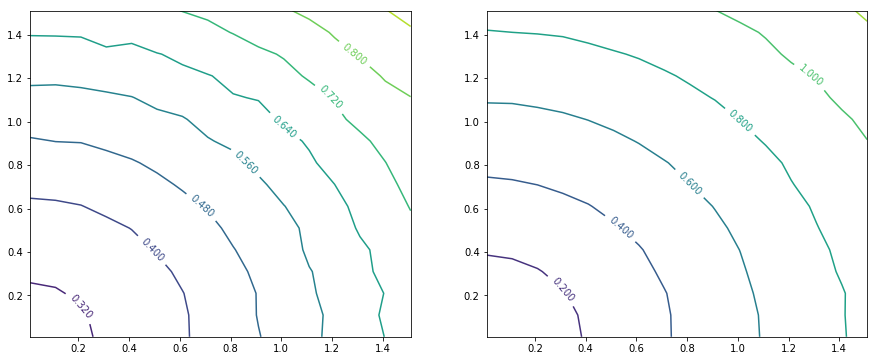

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (15, 6))

ax = axs[0]
CS = ax.contour(X, Y, m)
ax.clabel(CS, inline=1, fontsize=10)

ax = axs[1]
CS = ax.contour(X, Y, v)
ax.clabel(CS, inline=1, fontsize=10)

/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


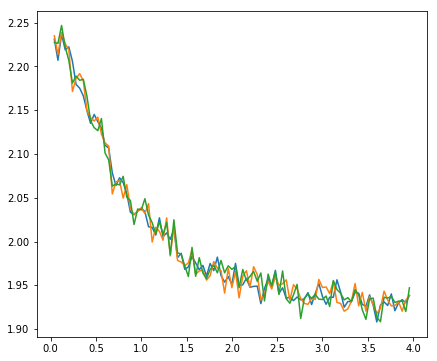

In [8]:
fig, axs = plt.subplots(1, figsize = (7, 6))

t = np.arange(0, 4, .04)

def test(s1, s2):
    result = np.log10(np.power(10, np.random.normal(0, s1, 40000)) 
                      + np.power(10, np.random.normal(0, s2, 40000)))
    return result.mean(), result.std()

f0t = np.array([test(s/np.sqrt(2), s/np.sqrt(2))[1] for s in t])
f1t = np.array([test(s/np.sqrt(5/4), s/2./np.sqrt(5/4))[1] for s in t])
f2t = np.array([test(s/np.sqrt(5), 2*s/np.sqrt(5))[1] for s in t])


def test(s1, s2):
    result = np.random.normal(0, s1, 40000) + np.random.normal(0, s2, 40000)
    return result.mean(), result.std()

ft = np.array([test(s, s/2.)[1] for s in t])

plt.plot(t, ft/f0t)
plt.plot(t, ft/f1t)
plt.plot(t, ft/f2t)
# plt.plot(t, ft/ft)


In [76]:
def distrib(sigmas):
    result = np.log10(np.array([np.power(10, np.random.normal(0, s, 40000)) for s in sigmas]).sum(0)/len(sigmas))
    return result

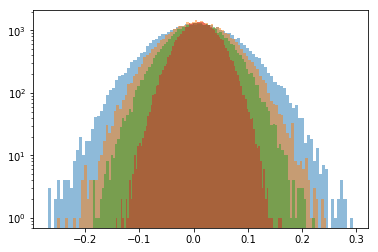

In [77]:
plt.hist(distrib([.1, .1]), 100, alpha = .5)
plt.hist(distrib([.1, .1, .1]), 100, alpha = .5)
plt.hist(distrib([.1, .1, .1, .1]), 100, alpha = .5)
plt.hist(distrib([.1, .1, .1, .1, .1, .1, .1, .1]), 100, alpha = .5)
# plt.xscale('log')
plt.yscale('log')
plt.show()

In [78]:
for q in range(1, 15):
    print(np.round(np.median(distrib(q*[.1])), 4))

0.001
0.0065
0.0078
0.0084
0.0095
0.01
0.01
0.0101
0.0101
0.0102
0.0102
0.0103
0.0107
0.0111


In [79]:
import pandas as pd

In [124]:
vals = []
qs = range(2, 22)
for q in qs:
    sigmas = np.arange(q)**2/np.max(np.arange(q)**2)
#     dist = distrib(q*[.01])
    dist = distrib(sigmas)
    vals += [[q, np.std(dist), np.var(dist)]]
df = pd.DataFrame(vals, columns = ['q', 'std', 'var'])

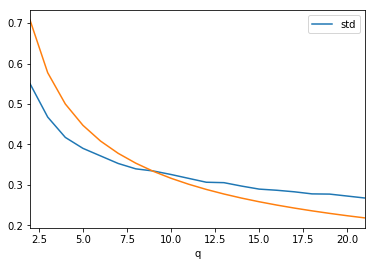

In [127]:
df.plot('q', 'std')

plt.plot(qs, 1/np.sqrt(qs))

## Additive (usual) case

In [38]:
mu0 = 3

s_i = 0.1
sigma = []
for n in range(1, 16):
    x0 = mu0*np.ones(n)

    t = []
    for m in range(10000):
        x1 = np.random.normal(0, s_i, n)
        t += [(x0 + x1).sum()/n]

    s2 = np.array(t)
    sigma += [np.std(s2)]

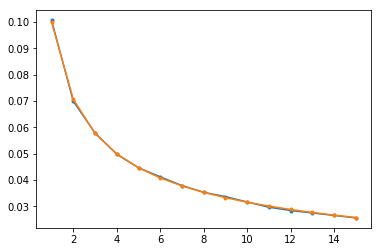

In [39]:
y = np.array(sigma)
x = range(1, 16)

plt.plot(x, y, marker = '.')
plt.plot(x, s_i/np.sqrt(x), marker = '.')
plt.show()

In [ ]:
# Geometric case.

# For different mu0, see what is the sigma and mu of the sum.

In [102]:
mu0 = 6

s_i = 0.18
sigma = []
mu = []
for i in range(5):
    n = 10**i
    
# for n in range(1, 16):
    
    x0 = mu0*np.ones(n)

    t = []
    for m in range(1000):
        x1 = np.random.normal(0, s_i, n)
#         t += [(x0 + x1).sum()/n]
        t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]

    s2 = np.array(t)
    sigma += [np.std(s2)]
    mu += [np.mean(s2)]


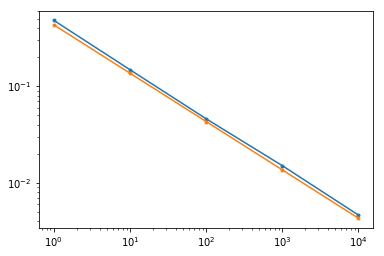

In [103]:
y = np.array(sigma)
# x = range(1, 16)
x = 10**np.arange(5)

plt.plot(x, y, marker = '.')
plt.plot(x, 2.4*s_i/np.sqrt(x), marker = '.')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [85]:
1/2.4

0.4166666666666667

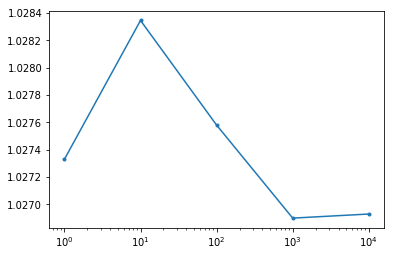

In [82]:
y = np.array(mu)
# x = range(1, 16)
x = 10**np.arange(5)

plt.plot(x, y, marker = '.')
# plt.plot(x, 2.3*s_i/np.sqrt(x), marker = '.')
plt.xscale('log')
# plt.yscale('log')
plt.show()